# Explore CITE Data for the Neurips 2021 Multimodal Data Integration Challenge

Welcome to the data exploration notebook for the CITE data from the Neurips 2021 Multimodal Data Integration Challenge. You can find full documentation for the competition at https://openproblems.bio/neurips_docs/

The goal for this notebook is to introduce you to the CITE gene expression (GEX) and antibody derived tag protein (ADT) datasets. 

Note, this data is present to facilitate exploration of the dataset released for the competition. There is metadata available here that won't be available to methods during evalutation on EvalAI. Please consult the documentation for the competition to learn more about what's available to methods for each task.

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%autoreload 2

In [11]:
import numpy as np
import pandas as pd
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

Processed data for the competition has already been downloaded to your Saturn Cloud environment. In the off chance it hasn't downloaded, you can always re-download using the following command:

```sh
aws s3 sync s3://openproblems-bio/public/ $HOME/data/ --no-sign-request
```

The data is stored in two AnnData objects, one for each modality. Full documentation for AnnData is [here](https://anndata.readthedocs.io/en/latest/). 

Let's load the cite data.

In [12]:
gex_data = "/tmp/public/cite/cite_gex_processed_training.h5ad"
adt_data = "/tmp/public/cite/cite_adt_processed_training.h5ad"

In [13]:
adata_gex = ad.read_h5ad(gex_data)
adata_adt = ad.read_h5ad(adt_data)

### What is the data?

Data in AnnData object is stored in `adata.X`. The shape of the data is accessible using `adata.shape` or `adata.[n_obs|n_vars]`

In [14]:
print(f"The GEX data has {adata_gex.n_obs} observations and {adata_gex.n_vars} features.")
print(f"The ADT data has {adata_adt.n_obs} observations and {adata_adt.n_vars} features.")

The GEX data has 9172 observations and 14910 features.
The ADT data has 9172 observations and 134 features.


As we can see, there are many more features in the GEX matrix than in the adt matrix. This is expected, because limitations in the molecular biology of antibody staining limits the number of unique antibodies than can be used in a single panel to 100-300. 

Additionally, this data has already been preprocessed, so ADT counts and genes detected in fewer than 20 cells were excluded.

### Preprocessing of gene expression

In this dataset, gene expression was measured using 3' capture of single-cell RNA as described in the [10X 3' Gene Expression Product Guide](https://support.10xgenomics.com/single-cell-gene-expression/library-prep/doc/user-guide-chromium-single-cell-3-reagent-kits-user-guide-v31-chemistry-dual-index-with-feature-barcoding-technology-for-cell-surface-protein). Note, single cell and single nucleus RNA are different. Not all RNA is found in the nucleus. Comparisons of nuclear and cytosolic RNA have been previously reported (e.g. [Bakken 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209648); [Abdelmoez 2018](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1446-9)) as have comparisons of single-nucleus and single-cell RNA sequencing ([Lake 2017](https://www.nature.com/articles/s41598-017-04426-w)).

For gene expression data, cells were filtered based on mitochondrial content, UMI counts per cell, and genes detected per cell. Size factors were then calculated using [scran](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7) and stored in `adata.obs["size_factors"]`. 

Counts were then normalized per cell by divided the UMI counts by the size factors. Original counts are stored in `adata.layers["counts"]`. The size factor normalized counts are stored in `adata.X`.

Finally, normalized counts are [log1p transformed](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html). These normalized counts are stores in `adata.layers["log_norm"]`.

More information about best practices for single-cell analysis can be found [here](https://www.embopress.org/doi/full/10.15252/msb.20188746).

### Preprocessing of protein ADT measurements

The protein data was measured using the [TotalSeq™-B Human Universal Cocktail, V1.0](https://www.biolegend.com/en-us/products/totalseq-b-human-universal-cocktail-v1dot0-20960) of 134 cell surface markers and 6 isotype controls. The isotype controls are stored in `adata.obsm["isotype_controls"]`. These controls do not target any human proteins and their expression should be considered background.


The ADT protein measurements were run through quality control based on the total number of ADTs (ranging from 1100-1200 to 24000 across samples), the number of proteins captured in each cell (with a lower limit of 80) and the ADT count of the 6 isotype controls summed up in each cell (ranging from 1 to 100).


Since the total number of captured ADTs is limited, absolute ADT counts appear to be lower if highly abundant proteins are present. To account for this effect, normalization was performed using the centered log ratio (CLR) transformation. CLR counts are stored in `adata.X` and the raw counts are stored in `adata.layers["counts"]`.

### Feature metadata

More information about the features are available in the `.var` DataFrames of each object

#### GEX feature metadata

The GEX `adata.var` DataFrames have the following columns:

* `.var.index` - [Ensembl Gene Names](https://m.ensembl.org/info/genome/genebuild/gene_names.html) for each gene
* `.var["gene_ids"]` - [Ensembl Stable IDs](https://useast.ensembl.org/info/genome/stable_ids/index.html) used to uniquely track genes whose Gene Names may change over time.
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `GEX` for all genes
* `.var["genome"]` - The [Genome Assembly](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/) used for read mapping.
* `.var["n_cells-[batch]"]` - The number of cells in `[batch]` in which the gene was detected.
* `.var["highly_variable-[batch]"]` - Whether the gene was determined to be [highly variable](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) in `[batch]`

In [15]:
adata_gex.var

,gene_ids,feature_types,genome,n_cells-s1d1,highly_variable-s1d1,n_cells-s1d2,highly_variable-s1d2
AL627309.1,ENSG00000238009,GEX,GRCh38,21,False,20,False
AL627309.5,ENSG00000241860,GEX,GRCh38,69,False,91,False
LINC01409,ENSG00000237491,GEX,GRCh38,303,False,376,False
LINC01128,ENSG00000228794,GEX,GRCh38,703,True,406,True
LINC00115,ENSG00000225880,GEX,GRCh38,103,True,86,False
...,...,...,...,...,...,...,...
MT-CYB,ENSG00000198727,GEX,GRCh38,6136,False,5468,False
AC011043.1,ENSG00000276256,GEX,GRCh38,51,False,25,False
AL592183.1,ENSG00000273748,GEX,GRCh38,482,True,174,True
AC240274.1,ENSG00000271254,GEX,GRCh38,53,False,66,False


#### ADT feature metadata

The ADT `adata.var` DataFrames have the following columns:

* `.var.index` - Protein markers for each ADT
* `.var["feature_types"]` - Denotes the each feature as a gene expression feature. Should be `ADT` for all peaks

In [16]:
adata_adt.var

,feature_types
CD86,ADT
CD274,ADT
CD270,ADT
CD155,ADT
CD112,ADT
...,...
HLA-E,ADT
CD82,ADT
CD101,ADT
CD88,ADT


### Observation metadata

There is also information about the observations in the `.obs` DataFrame of each AnnData object.

#### Gene expression observation metadata

The GEX `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["n_genes_by_counts"]` - The number of genes with at least 1 count in a cell. 
* `.obs["pct_counts_mt"]` - Percent of UMI counts mapped to mitochondrial genes. 
* `.obs["n_counts"]` - Number of UMIs detected in the cell
* `.obs["n_genes"]` - Number of genes detected in the cell
* `.obs["size_factors"]` - The estimated size factor for the cell. See [OSCA Ch. 7 - Normalization](https://bioconductor.org/books/release/OSCA/normalization.html)
* `.obs["phase"]` - The [cell cycle](https://www.genome.gov/genetics-glossary/Cell-Cycle) phase for each cell as calculated by [scanpy.tl.score_genes_cell_cycle](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes_cell_cycle.html)
* `.obs["cell_type"]` - The cell type annotation of the cells from the GEX data
* `.obs["pseudotime_order_GEX"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

For more info on how the QC metrics were calculated, consult [scanpy.pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html)

In [17]:
adata_gex.obs

,n_genes_by_counts,pct_counts_mt,size_factors,phase,cell_type,pseudotime_order_GEX,batch
CGTGCTTCAGCACAGA-1-s1d1,1802,7.906026,0.878375,S,NK,NaN,s1d1
AGGAAATCAAGATCCT-1-s1d1,1591,4.409413,0.732101,G2M,Naive CD20+ B IGKC+,NaN,s1d1
CAGCGTGAGGGCAGTT-1-s1d1,1891,18.979080,0.947274,G2M,CD8 T CD49f+,NaN,s1d1
TGATTCTTCTGGGCAC-1-s1d1,1747,6.216874,0.819258,G2M,CD4+ T naive,NaN,s1d1
GGGTCACCAACAAAGT-1-s1d1,1671,7.263774,0.817488,G2M,CD4+ T activated integrinB7+,NaN,s1d1
...,...,...,...,...,...,...,...
TTTATGCTCGTGCACG-1-s1d2,630,1.239311,0.132133,G2M,Normoblast,0.833955,s1d2
AGCCAGCAGGTGCTAG-1-s1d2,1505,6.273001,0.615525,G2M,CD4+ T activated,NaN,s1d2
CCTTGTGTCCGCTAGG-1-s1d2,2274,8.260939,1.047466,G2M,ID2-hi myeloid prog,NaN,s1d2
ACGCACGTCCAATCTT-1-s1d2,2227,8.327764,1.089339,G2M,CD8 T CD57+ CD45RO+,NaN,s1d2


#### ADT observation metadata

The GEX `adata.obs` DataFrames have the following columns:
* `.obs.index` - The cell barcode for that observation with the batch label appended. 
* `.obs["n_antibodies_by_counts"]` - The number of ADTs with at least 1 count in a cell. 
* `.obs["total_counts"]` - Number of ADT UMIs detected in the cell
* `.obs["iso_count"]` - Total number of UMIs mapped to isotype controls*
* `.obs["cell_type"]` - The cell type annotation of the cells from the CITE data
* `.obs["pseudotime_order_ADT"]` - The [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) annotation for the developmental trajectories annotated in the data.
* `.obs["batch"]` - The batch from which the cell was sampled. Format is `s1d1` for Site 1 Donor 1.

*Isotype controls are non-targeting antibodies that represent background expression

In [18]:
adata_adt.obs

,n_antibodies_by_counts,total_counts,iso_count,cell_type,pseudotime_order_ADT,batch
CGTGCTTCAGCACAGA-1-s1d1,129,6181.0,8.0,NK,NaN,s1d1
AGGAAATCAAGATCCT-1-s1d1,117,2890.0,3.0,Naive CD20+ B IGKC+,NaN,s1d1
CAGCGTGAGGGCAGTT-1-s1d1,133,14333.0,18.0,CD8 T CD49f+,NaN,s1d1
TGATTCTTCTGGGCAC-1-s1d1,110,2993.0,4.0,CD4+ T naive,NaN,s1d1
GGGTCACCAACAAAGT-1-s1d1,126,5883.0,9.0,CD4+ T activated integrinB7+,NaN,s1d1
...,...,...,...,...,...,...
TTTATGCTCGTGCACG-1-s1d2,124,10277.0,19.0,Normoblast,0.956626,s1d2
AGCCAGCAGGTGCTAG-1-s1d2,125,4724.0,13.0,CD4+ T activated,NaN,s1d2
CCTTGTGTCCGCTAGG-1-s1d2,138,5932.0,12.0,ID2-hi myeloid prog,NaN,s1d2
ACGCACGTCCAATCTT-1-s1d2,105,1696.0,1.0,CD8 T CD57+ CD45RO+,NaN,s1d2


## Visualizing the data using UMAP

The exploratory datasets have already been preprocessed and prepared for visualization using [UMAP](https://umap-learn.readthedocs.io/en/latest/).

#### Visualizing Gene Expression

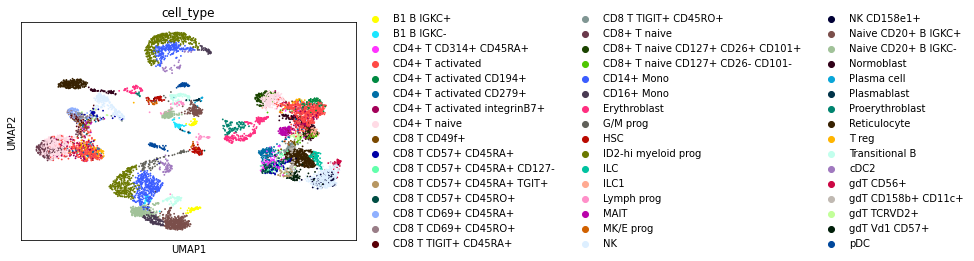

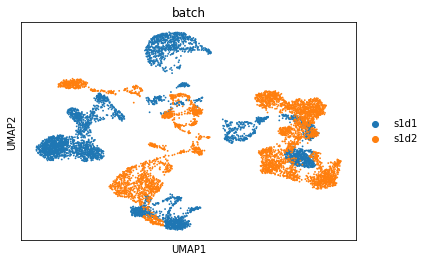

In [19]:
sc.pl.umap(adata_gex, color='cell_type')
sc.pl.umap(adata_gex, color='batch')

Note, for the `.obs["batch"]` metadata, the symbol represents the site and donor in the following format: `s1d1` for site 1, donor 1.

#### Visualizing ADT

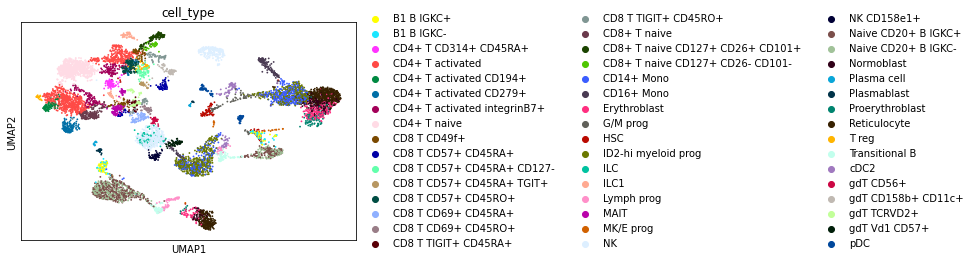

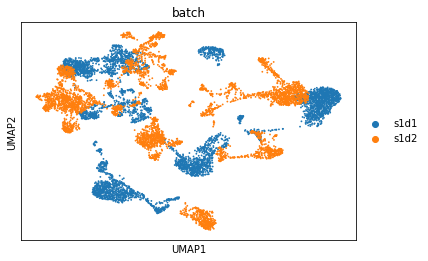

In [20]:
sc.pl.umap(adata_adt, color='cell_type')
sc.pl.umap(adata_adt, color='batch')

## Simple modality prediction

Task 1 of the competition is Modality Prediction. A full description of the task is available on the [Task Documentation](https://openproblems.bio/neurips_docs/about_tasks/task1_modality_prediction/).

Simply put, the goal is to take one modality as input and predict the other. Methods are given some training data in which modality 1 and modality 2 are known, and then a set of cells where only modality 1 is provided.

The censored training data for Phase 1 will be released on September 17, 2021. For now, you can make your own train / validation split in this notebook.

### Creating test / validation split

Let's start by using `s1d2` as our hold out sample.

In [21]:
train_cells = adata_gex.obs_names[adata_gex.obs["batch"] != "s1d2"]
test_cells  = adata_gex.obs_names[adata_gex.obs["batch"] == "s1d2"]

As we can see from the Task 1 documentation, methods for task one should expect the following input:
* `input_train_mod1`
* `input_train_mod2`
* `input_test_mod1`

Metrics then expect as input:
* `true_test_mod2`
* `pred_test_mod2`

With that, let's subset our data into these expected objects focusing on the subtask of predicting ADT from GEX. 

In [22]:
# This will get passed to the method
input_train_mod1 = adata_gex[train_cells]
input_train_mod2 = adata_adt[train_cells]
input_test_mod1 =  adata_gex[test_cells]

# This will get passed to the metric
true_test_mod2 =  adata_adt[test_cells]

### RMSE Metric

The metric for task 1 is RMSE on the `adata.layers["log_norm"]` data.

In [23]:
def calculate_rmse(true_test_mod2, pred_test_mod2):
    return  mean_squared_error(true_test_mod2.X.toarray(), pred_test_mod2.X, squared=False)


### Method

Let's try a method that runs linear regression on PCA transformed data before projecting the data back to the feature space.

In [24]:
def baseline_linear(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Baseline method training a linear regressor on the input data'''
    input_mod1 = ad.concat(
        {"train": input_train_mod1, "test": input_test_mod1},
        axis=0,
        join="outer",
        label="group",
        fill_value=0,
        index_unique="-", 
    )
    
    # Do PCA on the input data
    logging.info('Performing dimensionality reduction on modality 1 values...')
    embedder_mod1 = TruncatedSVD(n_components=50)
    mod1_pca = embedder_mod1.fit_transform(input_mod1.X)
    

    
    # split dimred mod 1 back up for training
    X_train = mod1_pca[input_mod1.obs['group'] == 'train']
    X_test = mod1_pca[input_mod1.obs['group'] == 'test']
    y_train = input_train_mod2.X.toarray()
    
    assert len(X_train) + len(X_test) == len(mod1_pca)
    
    logging.info('Running Linear regression...')
    
    reg = LinearRegression()
    
    # Train the model on the PCA reduced modality 1 and 2 data
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    # Project the predictions back to the modality 2 feature space
    
    pred_test_mod2 = ad.AnnData(
        X = y_pred,
        obs = input_test_mod1.obs,
        var = input_train_mod2.var,
    
    )
    
    # Add the name of the method to the result
    pred_test_mod2.uns["method"] = "linear"
    
    return pred_test_mod2

Now, for comparison, let's create a simple dummy method that simply returns the mean for the input modality 2 data. This method returns an identical prediction for all cells and ignores the modality 1 information altogether.

In [25]:
def baseline_mean(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Dummy method that predicts mean(input_train_mod2) for all cells'''
    logging.info('Calculate mean of the training data modality 2...')
    y_pred = np.repeat(input_train_mod2.X.mean(axis=0).reshape(-1,1).T, input_test_mod1.shape[0], axis=0)
    
    # Prepare the ouput data object
    pred_test_mod2 = ad.AnnData(
        X=y_pred,
        obs=input_test_mod1.obs,
        var=input_train_mod2.var,
    )
    
    pred_test_mod2.uns["method"] = "mean"

    return pred_test_mod2

#### Run comparison

Let's run the simple and dummy method side-by-side and compare performance.

In [26]:
for method in [baseline_linear, baseline_mean]:
    # Run prediction
    pred_test_mod2 = method(input_train_mod1, input_train_mod2, input_test_mod1)
    # Calculate RMSE
    rmse = calculate_rmse(true_test_mod2, pred_test_mod2)
    # Print results
    print(f'{pred_test_mod2.uns["method"]} had a RMSE of {rmse:.4f}')

linear had a RMSE of 0.5481
mean had a RMSE of 0.6846


As expected, the linear model does better than the dummy method. Now the challenge is up to you! Can you do better than this baseline?